# Continuous Attractor Neural Network with Adaptation  
## The dynamics of CANN with SFA  
### Synaptic current dynamics (a negative feedback $V$ is added to the model):  
$$  
\tau \frac{dU(x,t)}{dt} = -U(x,t)+\int J(x,x')r(x',t)dx' + I^{ext} - V(x,t)  
$$  
### Spike frequency adaptation (dynamics of V):  
$$  
\tau_v \frac{dV(x,t)}{dt} = -V(x,t)+ mU(x,t)  
$$  
## Customize a CANN with SFA

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})
plt.rcParams['font.sans-serif'] = ['Times New Roman']


class CANN1D_SFA(bp.NeuGroupNS):
  def __init__(self, num, m = 0.1, tau=1., tau_v=10., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D_SFA, self).__init__(size=num, **kwargs)

    # 初始化参数
    self.tau = tau
    self.tau_v = tau_v #time constant of SFA
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0
    self.m = m #SFA strength
      
    # 初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 初始化变量
    self.u = bm.Variable(bm.zeros(num))
    self.v = bm.Variable(bm.zeros(num)) #SFA current
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵
    self.center = bm.Variable(0.0)  # 中心位置

    # 定义积分函数
    self.integral = bp.odeint(self.derivative)

  # 微分方程
  @property
  def derivative(self):
    du = lambda u, t, v, Irec, Iext: (-u + Irec + Iext-v) / self.tau
    dv = lambda v, t, u: (-v + self.m*u) / self.tau_v
    return bp.JointEq([du, dv])

  # 将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(
      -0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, x=None):
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2))
    Irec = bm.dot(self.conn_mat, r)
    u, v = self.integral(self.u, self.v, bp.share['t'],Irec, self.input)
    self.u[:] = bm.where(u>0,u,0)
    self.v[:] = v
    self.input[:] = 0.  # 重置外部电流
    # update center
    cen = bm.argmax(self.u)
    self.center.value = bm.sum(self.x * bm.roll(self.u,bm.int(self.num/2)-cen)) / bm.sum(self.u) + self.x[cen]

## Travelling wave without input drive

  0%|          | 0/1000 [00:00<?, ?it/s]

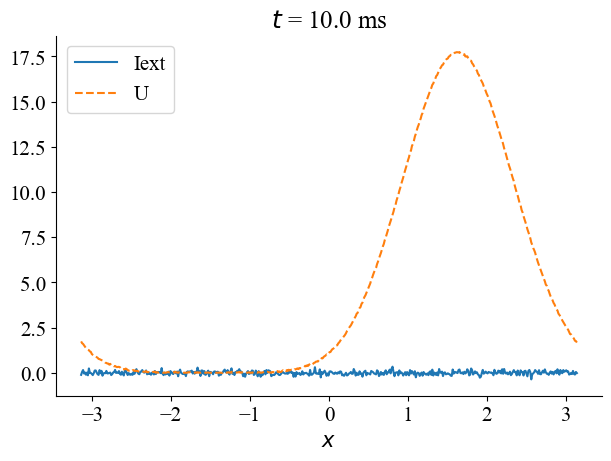

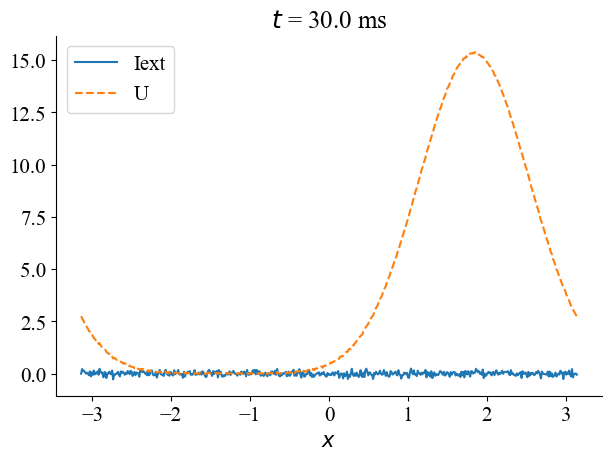

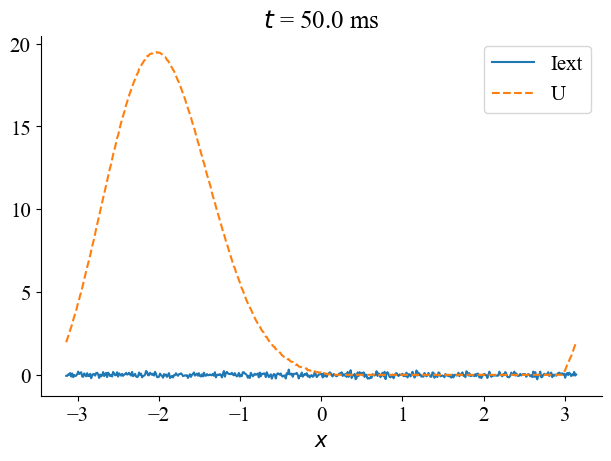

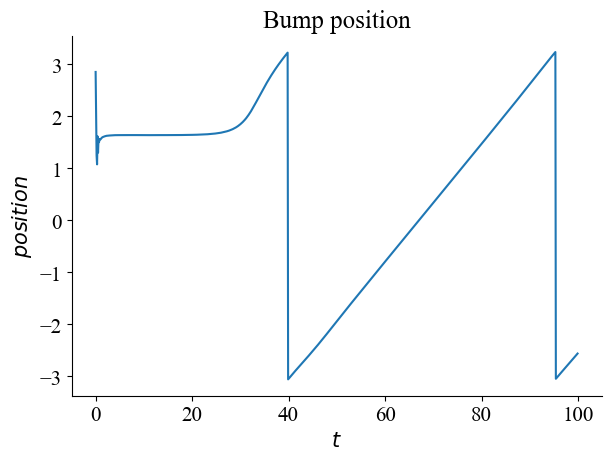

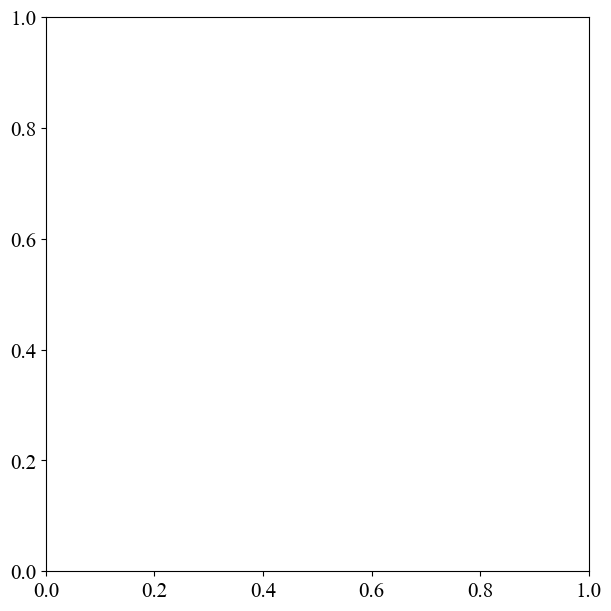

In [2]:
def traveling_wave(num=512,m=0.1,k=0.1):
    # 生成CANN
    cann_sfa = CANN1D_SFA(num=num, m=m,k=k)

    # 生成外部刺激
    dur = 100.
    noise_level = 0.1
    Iext = bm.random.normal(0., noise_level, (int(dur / bm.get_dt()), num))
    duration = dur
    # 运行数值模拟
    runner = bp.DSRunner(cann_sfa, inputs=['input', Iext, 'iter'], monitors=['u','center'])
    runner.run(duration)

    # 可视化
    def plot_response(t):
        fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann_sfa.x, I, label='Iext')
        ax.plot(cann_sfa.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
        # plt.savefig(f'CANN_t={t}.pdf', transparent=True, dpi=500)

    plot_response(t=10.)
    plot_response(t=30.)
    plot_response(t=50.)

    # plot centers
    fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(runner.mon.ts, runner.mon.center)
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$position$')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Bump position')
    

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann_sfa.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann_sfa.x, 'legend': 'Iext'}],
        frame_step=1,
        frame_delay=40,
        show=True,
    )
    plt.show()

traveling_wave(num=512,m=0.5,k=0.1)

## Oscillatory tracking

  0%|          | 0/26000 [00:00<?, ?it/s]

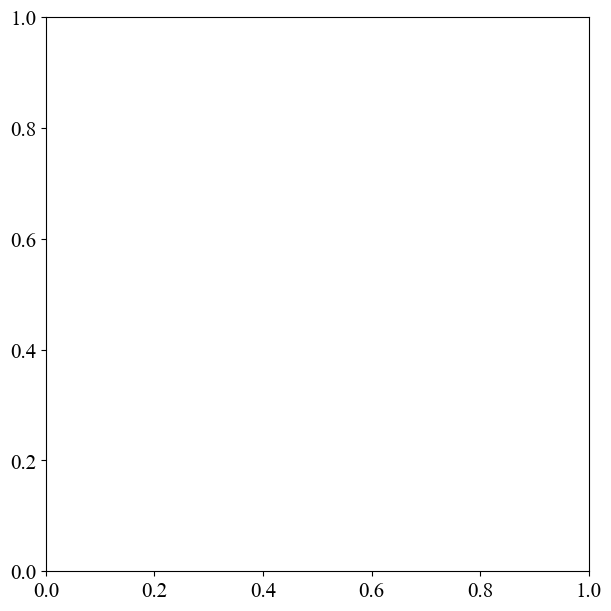

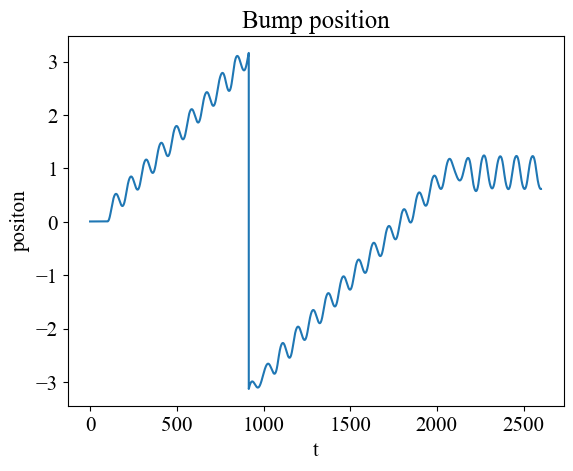

In [3]:
def oscillatory(num=512, tau=1., tau_v=50., k=1., a=0.3, A=0.2, J0=1., m=0.3):
    cann_osc = CANN1D_SFA(num=512, tau=tau, tau_v=tau_v, k=k, a=a, A=A, J0=J0,m=m)
    dur1, dur2, dur3 = 100., 2000., 500.
    num1 = int(dur1 / bm.get_dt())
    num2 = int(dur2 / bm.get_dt())
    num3 = int(dur3 / bm.get_dt())
    position = bm.zeros(num1 + num2 + num3)
    final_pos = cann_osc.a / cann_osc.tau_v * 0.6 * dur2
    position[num1: num1 + num2] = bm.linspace(0., final_pos, num2)
    position[num1 + num2:] = final_pos
    position = position.reshape((-1, 1))
    Iext = cann_osc.get_stimulus_by_pos(position)

    runner = bp.DSRunner(cann_osc,
                        inputs=('input', Iext, 'iter'),
                        monitors=['u', 'v', 'center'])
    runner.run(dur1 + dur2 + dur3)

    # visualize bump oscillation
    _ = bp.visualize.animate_1D(
    dynamical_vars=[
        {'ys': runner.mon.u, 'xs': cann_osc.x, 'legend': 'u'},
        # {'ys': runner.mon.v, 'xs': cann.x, 'legend': 'v'},
        {'ys': Iext*3, 'xs': cann_osc.x, 'legend': 'Iext'},
    ],
    frame_step=30,
    frame_delay=5,
    show=True,
    # save_path='osc.gif'
    )
    # visualize bump position
    _ = bp.visualize.line_plot(
    runner.mon.ts, runner.mon.center,
    xlabel='t', ylabel='positon',title='Bump position', show=True,
    )

    plt.show()

oscillatory()

## Levy flight  
$ \bar{m} = \tau/\tau_v$

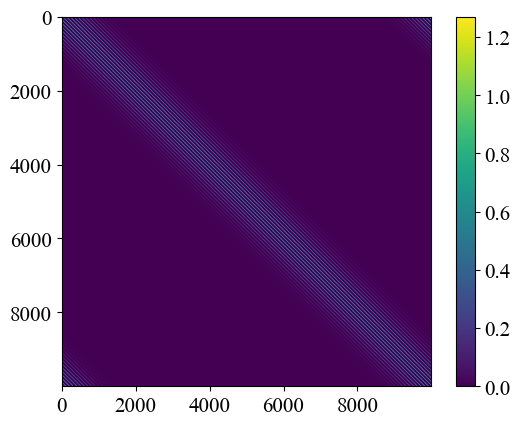

  0%|          | 0/1000 [00:00<?, ?it/s]

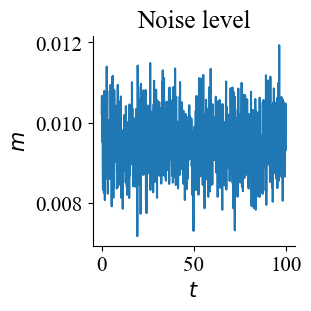

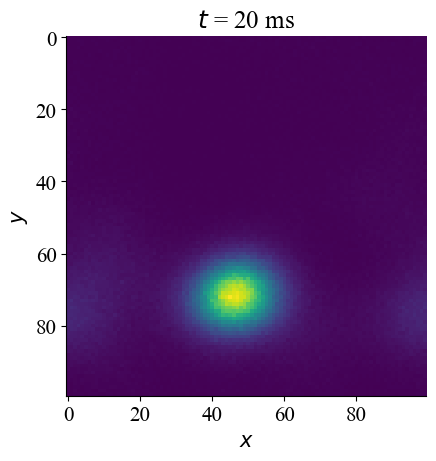

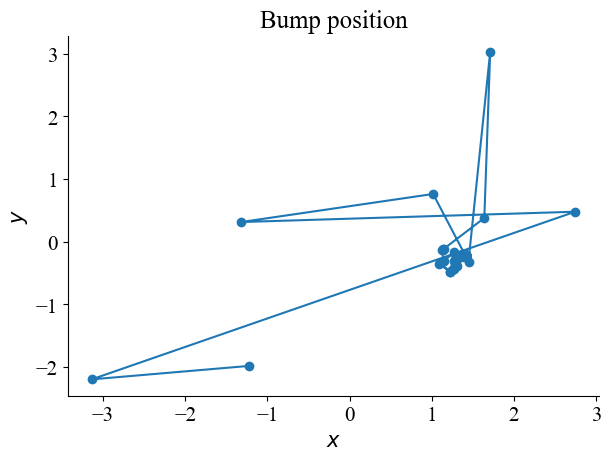

Array(value=Array([1.92279756e+00, 2.70515442e+00, 2.22919273e+00, 2.37519169e+00,
                   1.16035783e+00, 2.95258880e+00, 2.64829707e+00, 6.91320240e-01,
                   1.44054554e-02, 1.08502842e-02, 1.75971519e-02, 1.64175019e-01,
                   1.83669701e-01, 3.09286594e-01, 1.77832901e-01, 1.58060808e-02,
                   1.77976236e-01, 2.78244633e-02, 4.09397632e-02, 4.92170677e-02,
                   9.54048485e-02, 2.66398229e-02, 2.29556598e-02, 1.82688460e-02,
                   1.38865644e-02, 1.00807995e-02, 6.41700849e-02, 7.32507976e-03,
                   5.73475584e-02, 2.67652515e-03, 2.10681558e-03, 1.65017555e-03,
                   1.31356972e-03, 9.87479580e-04, 6.08600501e-04, 4.53162909e-04,
                   4.60728275e-04, 2.23420444e-04, 2.25169540e-04, 1.82601216e-04,
                   3.46974084e-05, 1.98458976e-04, 1.13080001e-04, 4.24840218e-05,
                   7.34830319e-05, 1.22088881e-04, 4.90168022e-05, 5.16299078e-05,
    

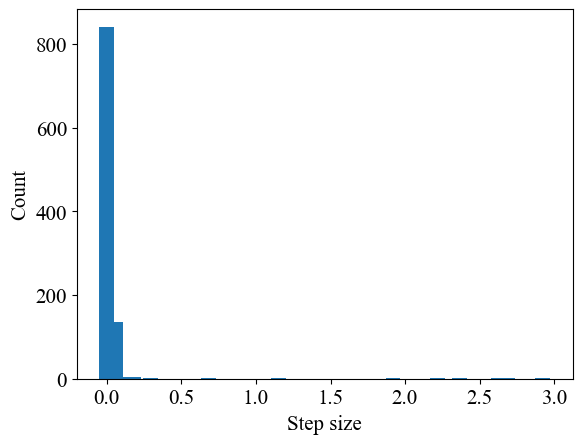

In [26]:
import matplotlib.pyplot as plt
import jax
import brainpy as bp
import brainpy.math as bm
import numpy as np

class CANN2D(bp.dyn.NeuDyn):
  def __init__(self, length, tau=1.,tauv=10., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi,m=2.,sigma_m=0.2, name=None):
    super(CANN2D, self).__init__(size=(length, length), name=name)

    # parameters
    self.length = length
    self.tau = tau  # The synaptic time constant
    self.tauv = tauv #time constant of SFA
    self.k = k  # Degree of the rescaled inhibition
    self.a = a  # Half-width of the range of excitatory connections
    self.A = A  # Magnitude of the external input
    self.J0 = J0  # maximum connection value
    self.m = m
    self.sigma_m = sigma_m
    self.noise_m = bm.Variable(bm.zeros(1))  # The noisy SFA strength

    # feature space
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.rho = length / self.z_range  # The neural density
    self.dx = self.z_range / length  # The stimulus density
    self.x = bm.arange(-bm.pi,bm.pi,self.dx)  # The encoded feature values

    # The connections
    self.conn_mat = self.make_conn()

    # variables
    self.r = bm.Variable(bm.zeros((length, length)))
    self.u = bm.Variable(bm.zeros((length, length)))
    self.input = bm.Variable(bm.zeros((length, length)))
    self.v = bm.Variable(bm.zeros((length, length))) #SFA current

    # The integral
    self.integral = bp.odeint(self.derivative)

    # center
    self.center = bm.Variable(bm.zeros(2))  # 中心位置

  def show_conn(self):
    plt.imshow(bm.as_numpy(self.conn_mat))
    plt.colorbar()
    plt.show()

  def dist(self, d):
    v_size = bm.asarray([self.z_range, self.z_range])
    d = bm.remainder(d, v_size)
    return bm.where(d > v_size / 2, v_size - d, d)

  def make_conn(self):
    x1, x2 = bm.meshgrid(self.x, self.x)
    value = bm.stack([x1.flatten(), x2.flatten()]).T

    @jax.vmap
    def get_J(v):
      d = self.dist(bm.abs(v - value))
      d = bm.linalg.norm(d, axis=1)
      # d = d.reshape((self.length, self.length))
      Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
      return Jxx

    return get_J(value)

  def get_stimulus_by_pos(self, pos):
    assert bm.size(pos) == 2
    x1, x2 = bm.meshgrid(self.x, self.x)
    value = bm.stack([x1.flatten(), x2.flatten()]).T
    d = self.dist(bm.abs(bm.asarray(pos) - value))
    d = bm.linalg.norm(d, axis=1)
    d = d.reshape((self.length, self.length))
    return self.A * bm.exp(-0.25 * bm.square(d / self.a))
  
  @property
  def derivative(self):
    du = lambda u, t, v, Irec, Iext: (-u + Irec + Iext-v) / self.tau
    dv = lambda v, t, u, m : (-v + m*u) / self.tauv
    return bp.JointEq(du, dv)

  def update(self):
    r1 = bm.square(self.u)
    r2 = 1.0 + self.k * bm.sum(r1)
    r = r1 / r2
    self.r.value = r
    interaction = (self.r.flatten() @ self.conn_mat).reshape((self.length, self.length))
    # self.u.value = self.u + (-self.u + self.input + interaction) / self.tau * bp.share['dt']
    self.noise_m.value = bm.random.normal(self.m, self.sigma_m, 1)
    u,v = self.integral(self.u, self.v, bp.share['t'], interaction, self.input, self.noise_m)
    self.u[:] = bm.where(u>0,u,0)
    self.v[:] = v
    self.input[:] = 0.
     # update center
    cen_idx = bm.argmax(r)
    cen_idx_x = cen_idx // self.length
    cen_idx_y = cen_idx % self.length
    r_temp = bm.roll(self.r, bm.int(self.length/2)-cen_idx_x, axis=0)
    r_temp = bm.roll(r_temp, bm.int(self.length/2)-cen_idx_y, axis=1)
    # calculate center of mass using r
    ave_x = bm.sum(r_temp@self.x) / bm.sum(self.r) + self.x[cen_idx_x]
    ave_y = bm.sum(self.x@r_temp.T) / bm.sum(self.r) + self.x[cen_idx_y]
    self.center.value = bm.asarray([ave_x,ave_y])

cann = CANN2D(length=100, k=0.05,a=bm.pi/10, m=0.0095, sigma_m=0.0007, tau=1., tauv=100.,J0=1.)

cann.show_conn()

# encoding
dur1,dur2 = 0,100.
dur = dur1 + dur2
num = int(dur / bm.get_dt())
num1 = int(dur1 / bm.get_dt())
num2 = int(dur2 / bm.get_dt())
noise_level = 0.1
Iext = bm.zeros((int(dur / bm.get_dt()), cann.length, cann.length))
Iext[:num1] = cann.get_stimulus_by_pos([0.,0.])
Iext[num1:] = bm.random.normal(0., noise_level, [num2,cann.length,cann.length])#)#(int(dur / bm.get_dt())
duration = dur
runner = bp.DSRunner(cann,
                     inputs=['input', Iext, 'iter'],
                     monitors=['r','center','noise_m'])
runner.run(dur)

centers = runner.mon.center[1:]

# visualize noise_m
fig, gs = bp.visualize.get_figure(1, 1, 3, 3)
ax = fig.add_subplot(gs[0, 0])
ax.plot(runner.mon.ts, runner.mon.noise_m)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$m$')
ax.set_title('Noise level')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



#visualize a 2d bump in the 200th time step
fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
ax = fig.add_subplot(gs[0, 0])
ts = 20
u = runner.mon.r[ts]
ax.imshow(u)
ax.set_title(r'$t$' + ' = {} ms'.format(ts))
ax.set_xlabel(r'$x$') 
ax.set_ylabel(r'$y$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# visualize 2D center
fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
ax = fig.add_subplot(gs[0, 0])
ax.plot(centers[:,0],centers[:,1],'-o')
# xlim as -pi,pi
# ax.set_xlim([-bm.pi,bm.pi])
# ax.set_ylim([-bm.pi,bm.pi])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title('Bump position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

steps = bm.diff(centers,axis=0)
# make steps in [-pi,pi)
steps = cann.dist(steps)

steps = bm.sqrt(bm.sum(bm.square(steps),axis=1))
h,bins = np.histogram(steps,bins=100)
plt.bar(bins[:-1],h,width=0.05)
plt.xlabel('Step size')
plt.ylabel('Count')
plt.show()

# CANN with STP

In [5]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})
plt.rcParams['font.sans-serif'] = ['Times New Roman']


class CANN1D_STP(bp.NeuGroupNS):
  def __init__(self, num, tau=1., tau_f=1., tau_d=30., G=0.2, k=8.1, a=0.5, A=10., J0=12.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D_STP, self).__init__(size=num, **kwargs)

    # 初始化参数
    self.tau = tau
    self.tau_f = tau_f #time constant of u
    self.tau_d = tau_d #time constant of h
    self.G = G
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0
      
    # 初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 初始化变量
    self.u = bm.Variable(bm.zeros(num))
    self.g = bm.Variable(bm.zeros(num)) #neuro-transmitter release probability
    self.h = bm.Variable(bm.ones(num)) #neuro-transmitter available fraction
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵

    # 定义积分函数
    self.integral = bp.odeint(self.derivative)

  # 微分方程
  @property
  def derivative(self):
    du = lambda u, t, Irec, Iext: (-u + Irec + Iext) / self.tau
    dg = lambda g, t, r: -g / self.tau_f + self.G * (1 - g) * r 
    dh = lambda h, t, g, r:  (1 - h) / self.tau_d - (g + self.G * (1 - g)) * h *r
    return bp.JointEq([du, dg, dh])

  # 将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(
      -0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, x=None):
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2)) 
    Irec = bm.dot(self.conn_mat, (self.g + self.G * (1 - self.g))*self.h*r)
    u, g, h = self.integral(u=self.u, g=self.g, h=self.h, t=bp.share['t'], Irec=Irec, Iext=self.input, r=r, dt=bm.dt)
    self.u[:] = bm.where(u>0,u,0)
    self.g.value = g
    self.h.value = h
    self.input[:] = 0.  # 重置外部电流

  0%|          | 0/10000 [00:00<?, ?it/s]

96


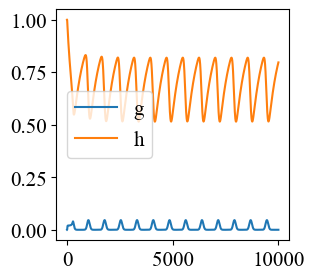

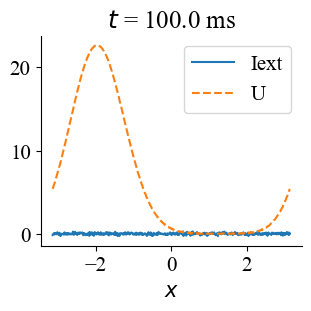

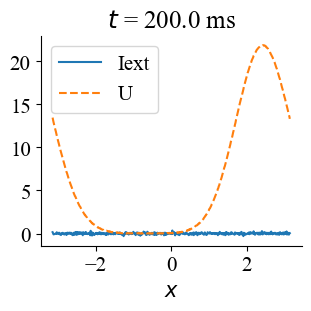

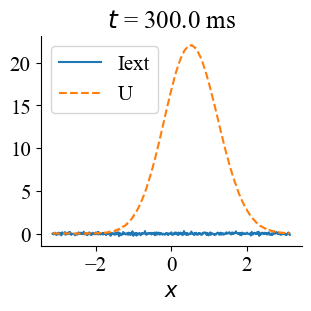

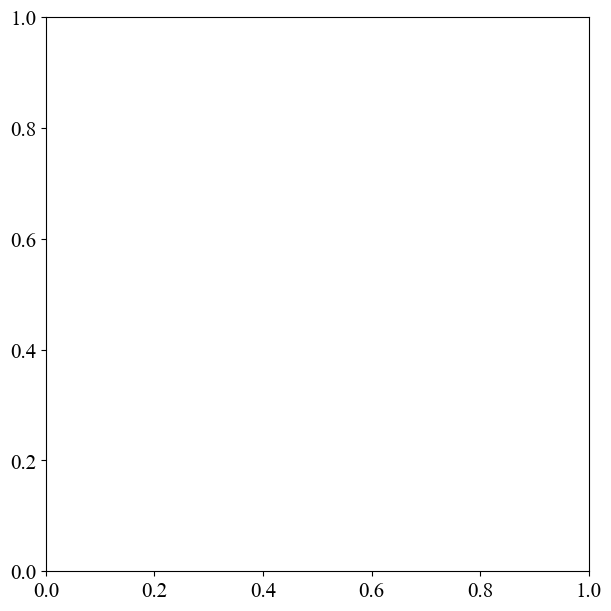

In [6]:
import numpy as np
def traveling_wave_STP(num=512,k=0.1,J0=12.,tau_d=1000,tau_f=1.,G=0.9):
    # 生成CANN
    cann_stp = CANN1D_STP(num=num, k=k,tau_d=tau_d,tau_f=tau_f,G=G, J0=J0)

    # 生成外部刺激
    dur = 1000.
    noise_level = 0.1
    Iext = bm.random.normal(0., noise_level, (int(dur / bm.get_dt()), num))
    duration = dur
    # 运行数值模拟
    runner = bp.DSRunner(cann_stp, inputs=['input', Iext, 'iter'], monitors=['u','g','h'])
    runner.run(duration)
    fig,ax = plt.subplots(figsize=(3,3))
    u = bm.as_numpy(runner.mon.u)
    max_index = np.argmax(u[1000,:])
    print(max_index)
    ax.plot(runner.mon.g[:,max_index],label='g')
    ax.plot(runner.mon.h[:,max_index],label='h')
    ax.legend()
    # 可视化
    def plot_response(t):
        fig, gs = bp.visualize.get_figure(1, 1, 3, 3)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann_stp.x, I, label='Iext')
        ax.plot(cann_stp.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
    plot_response(t=100.)
    plot_response(t=200.)
    plot_response(t=300.)

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann_stp.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann_stp.x, 'legend': 'Iext'}],
        frame_step=1,
        frame_delay=40,
        show=True,
    )
    plt.show()
    
traveling_wave_STP(G=0.5,tau_d=50)